# Data Transformations:

* The images are resized to 224x224 pixels for uniformity.Random horizontal flipping is applied to augment the dataset.
* Random rotation (up to 15 degrees) is used to introduce variability.
* Color jittering is applied to adjust brightness, contrast, saturation, and hue, making the model more robust.
* The images are converted to tensors using ToTensor(), scaling pixel values to the range [0, 1].
* Normalization is applied with mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225], ensuring consistent input distribution.

# Loading the Dataset:
The dataset is loaded using PyTorch’s ImageFolder class, which organizes images based on their subfolder structure. The applied transformations ensure the images are properly formatted for deep learning models.

# Output:

* The total number of images is printed: 2513.
* The available classes (car brands) in the dataset are displayed:


In [3]:
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


# DATA LODING

In [ ]:
data_dir = "/Car_brand_logos/archive/Test"

from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print(f"Total Images: {len(full_dataset)}")

print(f"Classes: {full_dataset.classes}")

Total Images: 400
Classes: ['hyundai', 'lexus', 'mazda', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen']


# SPLITTING DATASET ,TRAIN AND TEST

In [9]:
train_size = int(0.70 * len(full_dataset))

val_size = int(0.15 * len(full_dataset))  

test_size = len(full_dataset) - train_size - val_size 

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

batch_size = 32 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 280, Validation: 60, Test: 60


# Dataset Splitting and Batch Loading
This section of the code performs dataset splitting and batch loading to prepare the data for training, validation, and testing.

# Dataset Splitting:
The dataset is divided into three parts:


* 70% for training to help the deep learning model learn patterns.
* 15% for validation to tune hyperparameters and monitor overfitting during training.
* 15% for testing to evaluate model performance on unseen data.
  The split sizes are computed dynamically based on the total number of images.

# Random Split:
random_split is used to create three subsets:


* train_dataset (training data)
* val_dataset (validation data)
* test_dataset (testing data)

This ensures a randomized but controlled division of the dataset.

# Data Loaders:
Each subset is loaded into a DataLoader with a batch size of 32:


* The training loader (train_loader) shuffles the data to improve generalization.
* The validation loader (val_loader) and test loader (test_loader) do not shuffle the data, ensuring reproducibility during evaluation.

# Output:
The total number of images in each subset is printed, providing a summary of how the dataset has been divided.

# DATA VISUALIZATION

Sample images from training data:


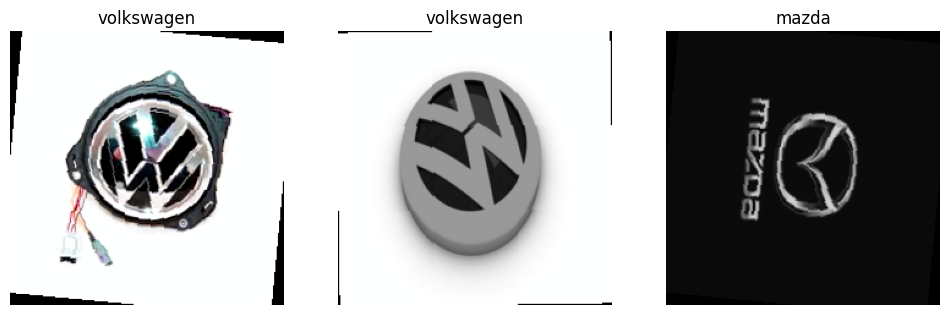

In [10]:
# --- Classes and Visualization ---
classes = full_dataset.classes

def show_images(loader, num_images=3):  
    dataiter = iter(loader)
    images, labels = next(dataiter)

    rows = 1
    cols = num_images  # Ensure it matches the number of images to display

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4))

    for i in range(num_images):
        ax = axes[i]  

        # De-normalize the image for display
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 
        img = np.clip(img, 0, 1)  # Clip values to ensure valid range

        ax.imshow(img)
        ax.set_title(classes[labels[i]])  # Display the class name
        ax.axis('off')  # Turn off the axes for cleaner visualization

    plt.show()

# --- Display Sample Images ---
print("Sample images from training data:")
show_images(train_loader)


# Class Labels:
The variable classes stores the class labels of the dataset, which will be used for displaying the image titles.

# Function show_images:

* This function takes a DataLoader as input and retrieves a batch of images and their corresponding labels.
* It uses matplotlib to display a specified number of images (default: 3).
* The images are un-normalized (scaled back to their original pixel range) using the formula:
  img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
* Each image is displayed with its corresponding class label as the title.
* The axes are hidden for a cleaner visualization.

# Output:
The function is called with train_loader to display sample images from the training set, providing insight into the dataset's appearance and diversity.

# BUILDING THE CNN MODEL

In [11]:
model = models.efficientnet_b0(pretrained=True)
num_classes = len(full_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# --- Training Loop ---
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    scheduler.step()

# --- Testing ---
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

/home/harishi/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harishi/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/harishi/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100.0%
Epoch 1/10: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


Epoch 1, Train Loss: 1.8371, Train Accuracy: 0.3429
Validation Loss: 1.3295, Validation Accuracy: 0.5667


Epoch 2/10: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]


Epoch 2, Train Loss: 0.8523, Train Accuracy: 0.7571
Validation Loss: 0.9335, Validation Accuracy: 0.7000


Epoch 3/10: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch 3, Train Loss: 0.3736, Train Accuracy: 0.9000
Validation Loss: 0.7538, Validation Accuracy: 0.7833


Epoch 4/10: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


Epoch 4, Train Loss: 0.2105, Train Accuracy: 0.9393
Validation Loss: 0.7416, Validation Accuracy: 0.8333


Epoch 5/10: 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]


Epoch 5, Train Loss: 0.1119, Train Accuracy: 0.9643
Validation Loss: 0.8848, Validation Accuracy: 0.8000


Epoch 6/10: 100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


Epoch 6, Train Loss: 0.1047, Train Accuracy: 0.9643
Validation Loss: 0.8994, Validation Accuracy: 0.7667


Epoch 7/10: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]


Epoch 7, Train Loss: 0.0357, Train Accuracy: 0.9893
Validation Loss: 0.7814, Validation Accuracy: 0.7833


Epoch 8/10: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


Epoch 8, Train Loss: 0.0411, Train Accuracy: 0.9893
Validation Loss: 0.9297, Validation Accuracy: 0.8000


Epoch 9/10: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Epoch 9, Train Loss: 0.0252, Train Accuracy: 0.9929
Validation Loss: 0.9111, Validation Accuracy: 0.7833


Epoch 10/10: 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]


Epoch 10, Train Loss: 0.0237, Train Accuracy: 1.0000
Validation Loss: 0.8533, Validation Accuracy: 0.8333


/tmp/ipykernel_322622/3324188888.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Loss: 0.7576, Test Accuracy: 0.8000


This section of the code defines and trains an EfficientNet-B0 model for car brand logo classification.

# Defining the Model:

* The pretrained EfficientNet-B0 model is loaded with pretrained=True, allowing it to leverage prior knowledge from large-scale image datasets.
* The classifier layer is modified to match the number of classes in the dataset.
* The model is transferred to the appropriate device (CPU/GPU) for training.

# Loss Function and Optimizer:

* CrossEntropyLoss is used as the loss function, which is suitable for multi-class classification.
* The AdamW optimizer is chosen with:
 * Learning rate (lr=0.001)
 * Weight decay (1e-4) to prevent overfitting.
* CosineAnnealingLR scheduler is applied to adjust the learning rate over training epochs.

# Training Process:

* The model is trained for 10 epochs, using a loop that:
 * Sets the model to train mode.
 * Iterates over the training data, computes loss, and updates weights.
 * Calculates training loss and accuracy after each epoch.
* Validation is performed at the end of each epoch:
 * The model switches to evaluation mode.
 * The validation set is used to compute loss and accuracy.
 * If validation accuracy improves, the best model is saved.

# Testing the Model:

* The best-performing model is loaded for testing.
* The test set is used to compute final loss and accuracy, evaluating the model on unseen data.

# Output:
The script prints training, validation, and test results, providing a detailed summary of the model’s performance.

# LOSS AND OPTIMIZER

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define Loss Function and Optimizer
This section of the code initializes the loss function and optimizer for training the model.

# Loss Function:

* CrossEntropyLoss() is used as the criterion, which is ideal for multi-class classification tasks.
* It computes the difference between the model’s predicted probabilities and the actual class labels.

# Optimizer:

* The Adam optimizer is selected with:Learning rate (lr=0.001) for weight updates.
* Adam adapts the learning rate for each parameter, making it efficient for deep learning tasks.


These components are essential for training the model, ensuring that the weights are updated correctly to minimize classification errors.

In [13]:
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Trainin
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/5 - Train Loss: 0.3139, Val Loss: 0.9785, Val Accuracy: 75.00%
Epoch 2/5 - Train Loss: 0.2960, Val Loss: 0.8956, Val Accuracy: 73.33%
Epoch 3/5 - Train Loss: 0.1826, Val Loss: 0.9113, Val Accuracy: 76.67%
Epoch 4/5 - Train Loss: 0.1488, Val Loss: 0.9726, Val Accuracy: 83.33%
Epoch 5/5 - Train Loss: 0.1588, Val Loss: 1.1126, Val Accuracy: 76.67%


# Train the Model
This section of the code implements the training and validation phases for training the model over multiple epochs.

# Training Process:

* The model is set to training mode using model.train().
* The training loop:
 * Moves the input images and labels to the appropriate device (CPU/GPU).
 * Resets gradients using optimizer.zero_grad().
 * Performs a forward pass to get predictions.
 * Computes the loss using criterion(outputs, labels).
 * Performs backpropagation (loss.backward()) to compute gradients.
 * Updates model weights using optimizer.step().
 * Tracks the running loss across all batches.
* The average training loss is computed and stored.

# Validation Process:

* The model is switched to evaluation mode using model.eval(), disabling gradient calculations.
* The validation loop:
 * Moves input images and labels to the appropriate device.
 * Performs a forward pass to get predictions.
 * Computes validation loss.
 * Tracks correct predictions to calculate accuracy.
* The average validation loss and validation accuracy are computed and stored.

# Epoch Summary:

* After each epoch, the script prints:
 * Training loss
 * Validation loss
 * Validation accuracy, expressed as a percentage.

This process ensures that the model is learning effectively while preventing overfitting.

# Plot Validation Loss Over Epochs

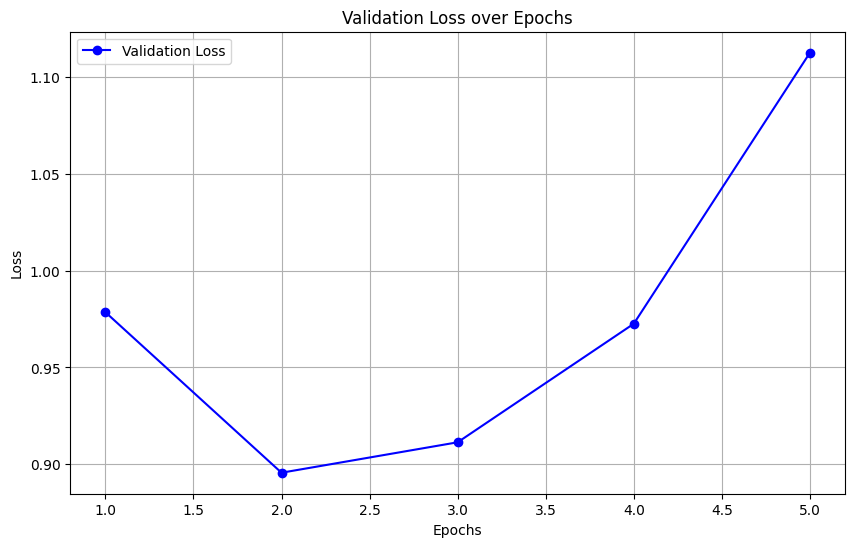

In [14]:
plt.figure(figsize=(10, 6)) 

plt.plot(range(1, num_epochs + 1), val_losses, marker='o', color='blue', label='Validation Loss') 

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.title('Validation Loss over Epochs')

plt.legend()

plt.grid(True)

plt.show()

# Evaluate the Model on Test Data

In [15]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.9352, Test Accuracy: 78.33%



1. Evaluation Mode: model.eval() disables dropout and batch normalization adjustments to ensure consistent inference.

2. Disabling Gradients: torch.no_grad() prevents gradient calculations, reducing memory usage and speeding up evaluation.

3. Loss Calculation: The model's predictions are compared with ground truth labels using a loss function, and the total loss is averaged over all batches.

4. Accuracy Measurement: The predicted class with the highest probability is compared against true labels, and the accuracy is computed as the percentage of correct predictions.

5. Final Metrics: The test loss and accuracy provide insight into the model's generalization ability on unseen data.


# SAVING THE MODEL

In [16]:
torch.save(model.state_dict(), "best_model.pth")

print("Model saved as 'best_model.pth'")

Model saved as 'best_model.pth'


# Final Prediction

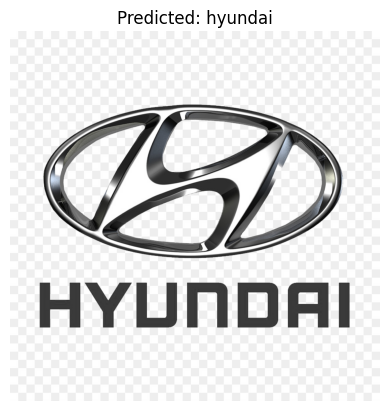

In [ ]:
file_path = "Test/hyundai/-car-hyundai-i30-hyundai-tucs-car-logo-5ad2754300c7e0.8761883915237420190032.jpg"
image = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


input_tensor = transform(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1) 

predicted_class = classes[predicted_label.item()]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()


# Summary:

This process enables the trained model to classify a single image, outputting the predicted car brand logo. The approach ensures proper image preprocessing, efficient inference, and visual presentation of the result.


# Image Classification Using a Trained Model
This code performs image classification using a pre-trained deep learning model in PyTorch. Below are the theoretical aspects of each step:

**1. Loading and Preprocessing the Image:**

* The image is loaded from the specified file path using Image.open(file_path).
* A transformation pipeline (transforms.Compose) is applied to ensure the image is in a format suitable for the model:
* Resizing: The image is resized to 224×224 pixels, which is the required input size for many pre-trained models.
* Conversion to Tensor: The image is converted into a PyTorch tensor, allowing it to be processed by the model.
* Normalization: The pixel values are normalized using the standard ImageNet mean and standard deviation, ensuring consistency in input distribution.

**2. Preparing the Input for Model Inference:**


* unsqueeze(0) adds an extra dimension, converting the single image tensor into a batch of size 1, as models expect batch inputs.
* The input tensor is moved to the appropriate computing device (CPU/GPU) using to(device).

**3. Model Evaluation and Prediction:**


* model.eval() sets the model to evaluation mode, disabling certain layers like dropout and batch normalization adjustments.
* torch.no_grad() ensures that gradients are not computed, reducing memory usage and improving efficiency.
* The model processes the input and produces an output tensor, representing class scores (logits).
* torch.max(output, 1) finds the class with the highest predicted probability.

**4. Mapping the Prediction to a Class Name:**

The predicted label is used to retrieve the corresponding class name from the classes list.

**5. Visualizing the Result:**


* The original image is displayed using plt.imshow(image).
* The predicted class is shown as the title of the imageplot.
* plt.axis('off') removes axis labels for a cleaner display.


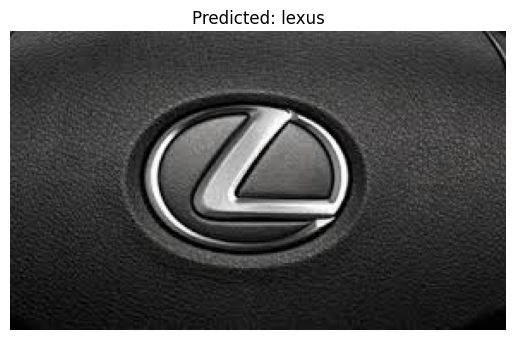

In [ ]:
file_path = "Test/lexus/images304.jpg"
image = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


input_tensor = transform(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1) 

predicted_class = classes[predicted_label.item()]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()

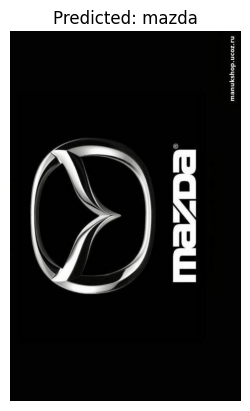

In [ ]:
file_path = "Test/mazda/27368.jpg"
image = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


input_tensor = transform(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1) 

predicted_class = classes[predicted_label.item()]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()

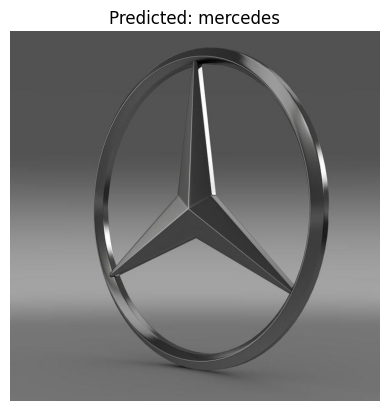

In [ ]:
file_path = "Test/mercedes/mrc22.jpg"
image = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


input_tensor = transform(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1) 

predicted_class = classes[predicted_label.item()]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()

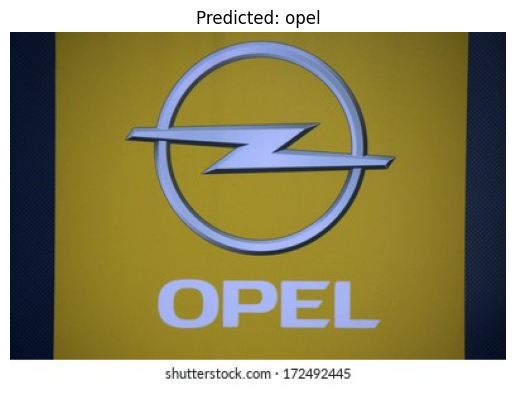

In [ ]:
file_path = "/opel/image-260nw-172492445.jpg"
image = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


input_tensor = transform(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1) 

predicted_class = classes[predicted_label.item()]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()

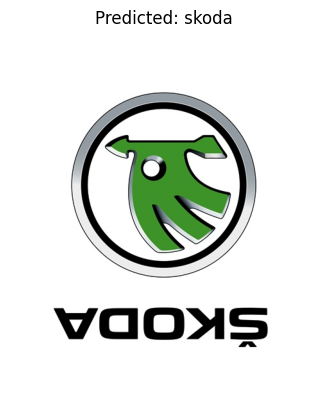

In [ ]:
file_path = "Test/skoda/Skoda-Logo.jpg"
image = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


input_tensor = transform(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1) 

predicted_class = classes[predicted_label.item()]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()

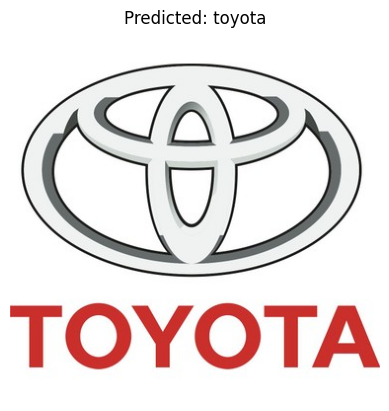

In [ ]:
file_path = "Test/toyota/11077057642546.jpg"
image = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


input_tensor = transform(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1) 

predicted_class = classes[predicted_label.item()]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()

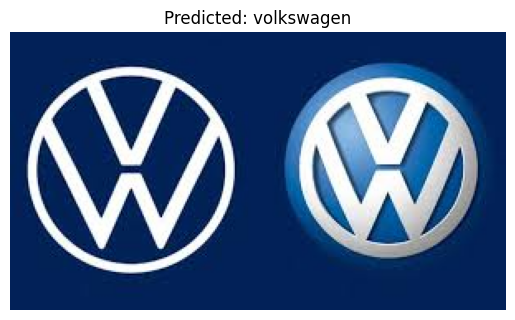

In [ ]:
file_path = "/volkswagen/images102.jpg"
image = Image.open(file_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


input_tensor = transform(image).unsqueeze(0)  

input_tensor = input_tensor.to(device)

model.eval()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_label = torch.max(output, 1) 

predicted_class = classes[predicted_label.item()]

plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')  
plt.show()